In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("hw04.ipynb")

<div class="alert alert-success" markdown="1">

#### Homework 4

# Exploratory Data Analysis and Missing Values

### EECS 398-003: Practical Data Science, Fall 2024

#### Due Thursday, September 26th at 11:59PM
    
</div>

## Instructions

Welcome to Homework 4! In this homework, you will practice exploratory data analysis. That is, you'll learn how to take messy data, clean it for analysis, draw meaningful visualizations from it, and impute missing values. See the [Readings section of the Resources tab on the course website](https://practicaldsc.org/resources/#readings) for supplemental resources.

You are given six slip days throughout the semester to extend deadlines. See the [Syllabus](https://practicaldsc.org/syllabus) for more details. With the exception of using slip days, late work will not be accepted unless you have made special arrangements with your instructor.

To access this notebook, you'll need to clone our [public GitHub repository](https://github.com/practicaldsc/fa24/). The [⚙️ Environment Setup](https://practicaldsc.org/env-setup) page on the course website walks you through the necessary steps. Once you're done, you'll submit your completed notebook to Gradescope.

Please start early and submit often. You can submit as many times as you'd like to Gradescope, and we'll grade your **most recent** submission. Remember that the public `grader.check` tests in your notebook are not comprehensive, and that your work will also be graded on hidden test cases on Gradescope after the submission deadline.

This homework is worth a total of **40 points**, 31 of which come from the autograder, **and 9 of which are manually graded by us** (Questions 5.1 and 5.2). The number of points each question is worth is listed at the start of each question. **The three parts of the assignment are independent, so feel free to move around if you get stuck**. Tip: if you're using Jupyter Lab, you can see a Table of Contents for the notebook by going to View > Table of Contents.

<a name='like-dataframe'>

</a>

<div class="alert alert-warning" markdown="1">
    
**Note**: Throughout this homework, you'll see statements like this frequently:

<blockquote>Complete the implementation of the function ____, which takes in a DataFrame <code>df</code> like <code>other_df</code> and _____.</blockquote>

What this means is that you should assume that `df` has the same number of columns as `other_df`, with the same column titles and data types, but potentially a different number of rows in a different order, with a potentially different index. You should always also assume that `df` has at least one row.

We have you implement functions like this to prevent you from hard-coding your answers to one specific dataset.

</div>

<div class="alert alert-danger" markdown="1">

`for`-loops are **allowed** in Questions 3 and 7. `for`-loops are **not allowed** in Questions 1, 2, 4, 5, and 6.

</div>

To get started, run the **two** import cells below, plus the cell at the top of the notebook that imports and initializes `otter`. The first cell below installs a new package that wasn't included in the `pds` conda environment that we'll need for Part 2.

In [3]:
!pip install -U kaleido

In [4]:
import pandas as pd
import numpy as np

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Preferred styles
pio.templates["pds"] = go.layout.Template(
    layout=dict(
        margin=dict(l=30, r=30, t=30, b=30),
        autosize=True,
        width=600,
        height=400,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+pds"

# Use plotly as default plotting engine
pd.options.plotting.backend = "plotly"

def save_and_show(fig, path):
    plotly.io.write_image(fig, path, width=1200)
    display(Image(path))

from IPython.display import display, Image

## Part 1: LendingClub Returns 💰

---

In this part, we'll continue working with the LendingClub dataset from [Lecture 7](https://practicaldsc.org/resources/lectures/lec07/lec07-filled.html) and [Lecture 8](https://practicaldsc.org/resources/lectures/lec08/lec08-filled.html). Run the cell below to load in the file `'data/loans.csv'` as a DataFrame and clean it the way that we did in lecture.

In [5]:
def clean_term_column(df):
    return df.assign(
        term=df['term'].str.split().str[0].astype(int)
    )

def clean_date_column(df):
    return (
        df
        .assign(date=pd.to_datetime(df['issue_d'], format='%b-%Y'))
        .drop(columns=['issue_d'])
    )

loans = (
    pd.read_csv('data/loans.csv')
    .pipe(clean_term_column)
    .pipe(clean_date_column)
)

As a refresher, each row of the dataset corresponds to a different loan that the LendingClub approved and paid out. This is only a sample of all loans the LendingClub ever gave out, and remember, each row corresponds to an actually approved loan, **not** a loan application.

Some of the key columns are:
- `'loan_amnt' (float)`: The amount of the loan, or how much the borrower borrowed.
- `'issue_d' (str)`: The date on which the loan was issued.
- `'term' (str)`: The length of the loan, that is, the amount of time the borrower has to pay the loan back.
- `'int_rate' (float)`: The interest rate the borrower will pay on their loan amount.
- `'fico_range_low' (float)`: The borrower's credit score at the time of their application.

In lecture, we drew visualizations to uncover a few key patterns in the data. We saw that:
- Interest rates tend to be higher for 60 month loans than 36 month loans.
- Borrowers with larger debt-to-income (DTI) ratios tend to receive higher interest rates than borrowers with lower DTIs.

One feature we didn't use very much in our preliminary analyses was borrowers' credit scores. Both interest rate (`'int_rate'`) and credit score (`'fico_range_low'`) are numerical features, so to look at the relationship between them, we can use a scatter plot:

In [6]:
px.scatter(loans, x='fico_range_low', y='int_rate',
           labels={'fico_range_low': 'Credit Score', 'int_rate': 'Interest Rate (%)'},
           title='Interest Rate vs. Credit Score')

There's a lot of overplotting here, meaning that many points are being plotted on top of one another. It does indeed seem that as credit scores increase, interest rates tend to decrease on average, but perhaps there's a better way to visualize this information.


One idea is to place credit scores into categories by **binning** them. According to [Experian](https://www.experian.com/blogs/ask-experian/credit-education/score-basics/what-is-a-good-credit-score/#s1), one of the three major credit bureaus in the US, FICO credit scores are described qualitatively as follows:

| Score | Category |
|---|---|
| 580 - 669 | Fair |
| 670 - 739 | Good |
| 740 - 799 | Very Good |
| 800 - 850 | Excellent |

There is actually also a bin below fair, named "poor" with a range of 300-579, but since `loans` doesn't have any poor credit scores, we'll exclude them from our exploration here. Note that while the `dtype` of `'fico_range_low'` is `float`, credit scores are actually integers.

Once we place credit scores into bins, we can visualize the distribution of interest rates separately for each credit score bin. Here, that would allow us to draw four separate distributions of interest rates – one for the fair group, one for the good group, one for the very good group, and one for the excellent group. Each one of those four distributions are **numerical distributions**, which we have several tools for visualizing, including histograms, box plots, and violin plots.

### Question 1: Boxing Day 🥊 <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">5 Points</div>

Complete the implementation of the function `create_boxplot`, which takes in a DataFrame `df` like `loans` and returns a `plotly` figure object containing a **box plot describing the distribution of interest rates, separately for each of the four credit score bins described below, and separately for the two loan lengths**. Here's an example of the plot you'll need to create:

<center><img src="imgs/example-q1.png" width=60%></center>

To create your figure, you'll use the `px.box` function and provide several arguments. This [`plotly` article](https://plotly.com/python/box-plots/) will be extremely helpful.

Before using `px.box`, though, you'll need to place credit scores into bins. There's a `pandas` function that will be helpful here. **Make sure the bins match those in our example plot exactly – inclusive of the left endpoint and exclusive of the right endpoint.** You'll need to hard-code these when creating your plot. You can assume that nobody has an exact credit score of 850. Once you've binned scores, you'll need to convert your Series of bin assignments to strings so that they can be used on the $x$-axis of a `px.box` figure.

Some additional guidance:
- Make sure your axis labels, legend labels, and title are the same as ours.
- You **must** change the colors of the two terms from the default colors to something else. We chose purple and gold. To do this, you'll need to manually specify what color you want for the `36` group and the `60` group; it is fine to hard-code these two term lengths when creating your plot.

Note that unlike in previous plotting questions, there **are** hidden tests, but they just check that the values in your plot are correct; the formatting is checked in the public tests. Remember that we will test `create_boxplot` on random samples of `loans`!

<div class="alert alert-danger">

Once you're done implementing `create_boxplot`, please comment out the line at the bottom of the cell below that says `create_boxplot(loans)`; otherwise, we won't be able to manually grade your work!

</div>

In [117]:
def create_boxplot(df):
    bins = [580, 670, 740, 800, 850]
    labels = ['[580, 670)', '[670, 740)', '[740, 800)', '[800, 850)']

    df['fico_range_bin'] = pd.cut(df['fico_range_low'], bins=bins, labels=labels, right=False).astype(str)

    return px.box(
        df, x='fico_range_bin', y='int_rate',
        color='term',
        title='Interest Rate vs. Credit Score',
        labels={
            'fico_range_bin': 'Credit Score Range',
            'int_rate': 'Interest Rate (%)',
            'term': 'Loan Length (Months)'
        },
        category_orders={
            'fico_range_bin': labels,
            'term': [36, 60]
        },
        color_discrete_sequence=['purple', 'gold']
    )

# When you're ready to submit your homework, please comment the line below out;
# otherwise, we won't be able to manually grade your work.
# create_boxplot(loans)

In [118]:
grader.check("q01")

q01 results: All test cases passed!

If you created your box plot correctly, you should have seen a few things:
- As borrowers' credit scores increase, both the median and variance in interest rates tend to decrease.
- Across the spectrum of credit scores, 60 month loans tend to have higher interest rates than 36 month loans, which we'd seen before in our plots in lecture.

Good to know!

Another factor that lenders like the LendingClub may look at when deciding whether or not to approve loans is the amount of **disposable income** potential borrowers have. With more disposable income, borrowers may be more likely to make their payments on time and less likely to **default** on their loans.

Disposable income is defined as:

$$
\text{Disposable Income} = \text{Gross Income} - \text{Federal Income Tax} - \text{State Income Tax} 
$$

The `'annual_inc'` column in `loans` contains each borrower's gross income – that is, their income before taxes are removed. But it doesn't contain any information about the taxes that each borrower owes on their income.

Run the cell below to define a DataFrame named `state_taxes_raw` that contains the tax brackets for each state in 2023 ([source](https://taxfoundation.org/data/all/state/state-income-tax-rates-2023/)).

In [9]:
state_taxes_raw_path = 'data/state_taxes_raw.csv'
state_taxes_raw = pd.read_csv(state_taxes_raw_path)
state_taxes_raw.head()

,State,Rate,Lower Limit
0,Ala.,2.00%,$0
1,"(a, b, c)",4.00%,$500
2,NaN,5.00%,"$3,000"
3,NaN,NaN,NaN
4,Alaska,none,NaN


Above, this is saying that Alabama has three state income tax brackets:
- Any income between \$0 and \$500 is taxed at 2%.
- Any income between \$500 and \$3000 is taxed at 4%.
- Any income above \$3000 is taxed at 5%.

These tax brackets are a mess! There are full rows of `NaN` values, not every row has a `'State'` filled in, and more. The brackets need more work to be compatible with, say, the `tax_owed` function we wrote in Homework 1. **In the next question, your job will be to reformatting the brackets in `state_taxes_raw` to be in a more useful format**. We won't actually go through the full process of computing disposable incomes, to be clear; you're just responsible for doing the cleaning.

### Question 2: Death and Taxes 💵 <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">7 Points</div>


Complete the implementation of the function `state_brackets`, which takes in a DataFrame `df` like `state_taxes_raw`. It should return a DataFrame, indexed by `'State'`, with a single column, `'bracket_list'`, that contains the tax brackets for each `'State'` as **lists of tuples** in the form `(tax_rate, bracket_lower_limit)`.

Example behavior is given below.

```python
>>> state_brackets(state_taxes_raw).head(4)
```

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>bracket_list</th>
    </tr>
    <tr>
      <th>State</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Ala.</th>
      <td>[(0.02, 0), (0.04, 500), (0.05, 3000)]</td>
    </tr>
    <tr>
      <th>Alaska</th>
      <td>[(0.0, 0)]</td>
    </tr>
    <tr>
      <th>Ariz.</th>
      <td>[(0.02, 0)]</td>
    </tr>
    <tr>
      <th>Ark.</th>
      <td>[(0.02, 0), (0.04, 4300), (0.05, 8500)]</td>
    </tr>
  </tbody>
</table>

Some added guidance:

- In the returned DataFrame, `'State'`s should appear in the same order in which they appear in the input DataFrame `df`. 

- In each list of tuples in the returned `'State'` column, the tax rates themselves should be proportions, stored as floats (e.g. `0.02` instead of `2` to represent 2%), and the income amounts should be stored as integers. Round the tax rate proportions to two decimal places to avoid any floating point precision errors, and make sure to correctly account for states with no state income tax (like Alaska) as we did in the example.
- If you're a little stuck on where to start, try to first clean the input DataFrame so it looks like the following DataFrame, and then figure out how to correctly group it:

    <table border="1" class="dataframe">
      <thead>
        <tr style="text-align: right;">
          <th></th>
          <th>State</th>
          <th>Rate</th>
          <th>Lower Limit</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <th>0</th>
          <td>Ala.</td>
          <td>0.02</td>
          <td>0</td>
        </tr>
        <tr>
          <th>1</th>
          <td>Ala.</td>
          <td>0.04</td>
          <td>500</td>
        </tr>
        <tr>
          <th>2</th>
          <td>Ala.</td>
          <td>0.05</td>
          <td>3000</td>
        </tr>
        <tr>
          <th>4</th>
          <td>Alaska</td>
          <td>0.00</td>
          <td>0</td>
        </tr>
        <tr>
          <th>6</th>
          <td>Ariz.</td>
          <td>0.02</td>
          <td>0</td>
        </tr>
      </tbody>
    </table>

- Make sure that any cleaning steps you perform are done within `state_brackets`, not directly to the `state_taxes_raw` DataFrame outside your notebook.
- We will call your function on subsets of `state_taxes_raw`, but only subsets that are still well-formed, i.e. where all of the rows for a particular `'State'` are in order and formatted the same way they are in `state_taxes_raw` (no randomly sampled subsets).
- You'll need to do some research to help you identify useful functions and methods to use (for instance, in how to fill in missing values in a particular way). For instance, you may need to `zip` ([documentation link](https://docs.python.org/3.3/library/functions.html#zip)) 🤐 at some point. 
- Don't forget that you can apply a function to every **row** of a DataFrame by using the DataFrame `apply` method with `axis=1`. `lambda` functions are your friend! 🫂
- This is quite an involved problem. Try to organize your work as best as you can, for instance, **by using many helper functions** and the `pipe` DataFrame method. **Nothing about this question requires the use of a `for`-loop, so don't use one!**

In [52]:
def state_brackets(df):
    # Clean input dataframe
    clean_df = df.copy()
    clean_df = clean_df.dropna(how='all')

    clean_df['State'] = (
        clean_df['State']
        .apply(lambda x: None if isinstance(x, str) and '(' in x else x)
        .ffill()
    )
    clean_df['Rate'] = (
        clean_df['Rate']
        .replace('none', None)
        .str.rstrip('%')
        .astype(float)
        .fillna(0)
        .round(0) / 100
    )
    clean_df['Lower Limit'] = (
        clean_df['Lower Limit']
        .str.lstrip('$')
        .str.replace(',', '')
        .fillna(0)
        .astype(int)
    )

    bracket_df = (
        clean_df.groupby('State').apply(
            lambda x: list(zip(x['Rate'], x['Lower Limit']))
        ).reset_index(name='bracket_list')
        .set_index('State')
    )

    return bracket_df

# If you've completed the question correctly,
# the first four rows below should match those in the
# example above.
state_brackets(state_taxes_raw)

,bracket_list
State,
Ala.,"[(0.02, 0), (0.04, 500), (0.05, 3000)]"
Alaska,"[(0.0, 0)]"
Ariz.,"[(0.02, 0)]"
Ark.,"[(0.02, 0), (0.04, 4300), (0.05, 8500)]"
Calif.,"[(0.01, 0), (0.02, 10099), (0.04, 23942), (0.0..."
Colo.,"[(0.04, 0)]"
Conn.,"[(0.03, 0), (0.05, 10000), (0.06, 50000), (0.0..."
D.C.,"[(0.04, 0), (0.06, 10000), (0.06, 40000), (0.0..."
Del.,"[(0.02, 2000), (0.04, 5000), (0.05, 10000), (0..."


In [53]:
grader.check("q02")

q02 results: All test cases passed!

## Part 2: Clean It Up 🧹

---

### Question 3: Reading Malformed CSVs <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">5 Points</div>

Up until now, most of the data we've had to work with was presented to us in a nice CSV file that we could call `pd.read_csv` on with no issues. But that won't always be the case! Sometimes there will be errors or problematic formatting.

`'data/malformed.csv'` is a file of comma-separated values, containing the following fields:

- `'first' (str)`: First name of person.
- `'last' (str)`: Last name of person.
- `'weight' (float)`: Weight of person (lbs).
- `'height' (float)`: Height of person (in).
- `'geo' (str)`: Location of person; comma-separated latitude/longitude.


Unfortunately, the entries contains errors with the placement of commas (`,`) and quotes (`"`) that cause `pd.read_csv` to fail parsing the file with the default settings. Don't believe us? Try using `pd.read_csv` on `'data/malformed.csv'` and look at what happens.

As a result, instead of using `pd.read_csv`, you must read in the file manually using Python's built-in `open` function.

Complete the implementation of the function `parse_malformed`, which takes in a string, `fp`, containing the path to a file, and returns a parsed, properly-typed DataFrame with the information in the corresponding file.

Example behavior is given below.

```python
>>> parse_malformed('data/malformed.csv').head(3)
```

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>first</th>
      <th>last</th>
      <th>weight</th>
      <th>height</th>
      <th>geo</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Julia</td>
      <td>Wagner</td>
      <td>142.0</td>
      <td>86.0</td>
      <td>39.8,15.4</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Angelica</td>
      <td>Rija</td>
      <td>155.0</td>
      <td>56.0</td>
      <td>38.2,-71.7</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Tyler</td>
      <td>Micajah</td>
      <td>116.0</td>
      <td>73.0</td>
      <td>38.0,6.9</td>
    </tr>
  </tbody>
</table>

Some guidance:
- The only kinds of issues you need your function to handle are comma and quote misplacements; don't try and find any other issues with the CSV. 
- You should assume that `'data/malformed.csv'` is a sample of a larger file that has the same sorts of errors, but potentially in different lines. For example, `'data/malformed.csv'` has an unnecessary quote `"` in line 4, but your function may be called on another CSV that has a perfectly fine line 4 but an unnecessary quote on some other line.
- So, **don't** implement `parse_malformed` assuming that the commas and quotes are mispositioned on specific lines; rather, implement `parse_malformed` such that it can handle these issues on every single line they appear in. A good way to proceed is to open `'data/malformed.csv'` and look carefully at the comma and quote placements.
- **You can** use a `for`-loop in this question.

In [76]:
def parse_malformed(fp):
    with open(fp, 'r') as file:
        header = file.readline().strip().split(',')
        rows = []

        for line in file:
            fields = []
            in_quotes = False
            curr_field = ''

            for char in line:
                if char == ',':
                    if curr_field == '':
                        continue
                    if in_quotes:
                        curr_field += char
                        continue
                    fields.append(curr_field)
                    curr_field = ''
                elif char == '"':
                    if curr_field: continue
                    in_quotes = not in_quotes
                else:
                    curr_field += char

            fields.append(curr_field.strip())

            first, last, weight, height, geo = fields
            weight = float(weight)
            height = float(height)
            geo = geo.strip('"')

            rows.append([first, last, weight, height, geo])

        df = pd.DataFrame(rows, columns=header)

    return df


# If you've completed the question correctly,
# the first three rows below should match those in the
# example above.
# Remember that we will call your function on
# other similarly-formatted CSVs!
parse_malformed('data/malformed.csv')

,first,last,weight,height,geo
0,Julia,Wagner,142.0,86.0,"39.8,15.4"
1,Angelica,Rija,155.0,56.0,"38.2,-71.7"
2,Tyler,Micajah,116.0,73.0,"38.0,6.9"
3,Kathleen,Nakea,163.0,69.0,"36.3,-86.8"
4,Axel,Ronit,95.0,74.0,"36.8,128.2"
...,...,...,...,...,...
95,Yasmeen,Jahron,135.0,84.0,"38.3,-127.3"
96,Meghan,Carlyann,101.0,66.0,"36.6,80.5"
97,Tess,Shree,146.0,68.0,"38.8,64.9"
98,Maria,Kalvyn,115.0,51.0,"37.1,-90.4"


In [77]:
grader.check("q03")

q03 results: All test cases passed!

### Question 4: High Potential Individuals 📈 <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">5 Points</div>

In 2022, the United Kingdom 🇬🇧 announced a new ["High Potential Individual" visa](https://www.gov.uk/high-potential-individual-visa/eligibility), which allows graduates of universities ranked in the Top 50 globally to move to the UK without a job lined up. This visa has been a subject of much debate, in part due to how much rankings play a role. Don't worry – the University of Michigan is on the list!

In the next two questions, you will clean and analyze a dataset of university rankings, collected from  [here](https://www.kaggle.com/datasets/mylesoneill/world-university-rankings?datasetId=) (though we have pre-processed and modified the original dataset for the purposes of this question).

Our version of the dataset is stored in `'data/universities.csv'`. We load it in as a DataFrame, `universities_raw`, below.

In [78]:
universities_raw = pd.read_csv('data/universities.csv')
universities_raw.head()

,world_rank,institution,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,control,city,state
0,1,Harvard University,"USA, 1",1,1,1,1,1,1,1.0,3,100.00,Private (non-profit),Cambridge,MA
1,2,Stanford University,"USA, 2",9,2,4,5,3,3,4.0,10,98.66,Private (non-profit),Stanford,CA
2,3,Massachusetts Institute of Technology,"USA, 3",3,11,2,15,2,2,2.0,1,97.54,Private (non-profit),Cambridge,MA
3,4,University of Cambridge,"UK, 1",2,10,5,11,6,12,13.0,48,96.81,NaN,NaN,NaN
4,5,University of Oxford,"United Kingdom, 2",7,13,10,7,12,7,9.0,15,96.46,NaN,NaN,NaN


Here are what the columns of `universities_raw` contain:

- `'world_rank'`: World rank of the institution.
- `'institution'`: Name of the institution.
- `'national_rank'`: Rank within the nation, formatted as `'country, rank'`.
- `'quality_of_education'`: Rank by quality of education.
- `'alumni_employment'`: Rank by alumni employment.
- `'quality_of_faculty'`: Rank by quality of faculty.
- `'publications'`: Rank by publications.
- `'influence'`: Rank by influence.
- `'citations'`: Rank by number of citations.
- `'broad_impact'`: Rank by broad impact.
- `'patents'`: Rank by number of patents.
- `'score'`: Overall score of the institution, out of 100.
- `'control'`: Whether the university is public or private.
- `'city'`: City in which the institution is located.
- `'state'`: State in which the institution is located.

There are (still) a few aspects of the dataset we need to clean before it's ready for analysis.

Complete the implementation of the function `clean_universities`, which takes in a DataFrame `df` like `universities_raw` and returns a cleaned DataFrame, cleaned according to the following specifications:

- Some `'institution'` names contain `'\n'` characters (e.g. `'University of Michigan\nAnn Arbor'`). Replace all instances of `'\n'` with `', '` (a comma and a space) in the `'institution'` column.

- Change the data type of the `'broad_impact'` column to `int`.

- Split `'national_rank'` into two columns, `'nation'` and `'national_rank_cleaned'`, where:
    - `'nation'` is the country (or its dependency) indicated in the first part of `'national_rank'`. 
        - Note that there are **3** countries that appear under different names for different schools. For all 3 of these countries, you should pick **the name that is longer** and use that name for every occurrence of the country. One of the 3 countries is **`'Czech Republic'`**, which also appears as **`'Czechia'`** – since these refer to the same country and `'Czech Republic'` is longer, all instances of either name should be replaced with `'Czech Republic'`. You need to find the other 2 countries on your own. 
        - These are the only 3 country names you need to handle.
    - `'national_rank_cleaned'` is the integer in the latter part of `'national_rank'`. Make sure that the values in this column are stored as integers. 
    - Don't include the original `'national_rank'` column in the output DataFrame.

Example behavior is given below.

```python
>>> clean_universities(universities).loc[[18], ['institution', 'nation', 'national_rank_cleaned']]
```

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>institution</th>
      <th>nation</th>
      <th>national_rank_cleaned</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>18</th>
      <td>University of Michigan, Ann Arbor</td>
      <td>United States</td>
      <td>15</td>
    </tr>
  </tbody>
</table>

In [101]:
def clean_universities(df):
    clean_df = df.copy()

    clean_df['institution'] = df['institution'].str.replace('\n', ', ')

    clean_df['broad_impact'] = df['broad_impact'].astype(int)

    clean_df[['nation', 'national_rank_cleaned']] = df['national_rank'].str.split(', ', expand=True)
    clean_df['nation'] = (
        clean_df['nation']
        .replace('Czechia', 'Czech Republic')
        .replace('USA', 'United States')
        .replace('UK', 'United Kingdom')
    )
    clean_df['national_rank_cleaned'] = clean_df['national_rank_cleaned'].astype(int)
    clean_df.drop('national_rank', axis=1, inplace=True)

    return clean_df

# Feel free to change this input to make sure your function works correctly.
# A good strategy is to make sure it works when you call it on a random subset of universities_raw,
# e.g. clean_universities(universities_raw.sample(100)).
clean_universities(universities_raw)

,world_rank,institution,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,control,city,state,nation,national_rank_cleaned
0,1,Harvard University,1,1,1,1,1,1,1,3,100.00,Private (non-profit),Cambridge,MA,United States,1
1,2,Stanford University,9,2,4,5,3,3,4,10,98.66,Private (non-profit),Stanford,CA,United States,2
2,3,Massachusetts Institute of Technology,3,11,2,15,2,2,2,1,97.54,Private (non-profit),Cambridge,MA,United States,3
3,4,University of Cambridge,2,10,5,11,6,12,13,48,96.81,NaN,NaN,NaN,United Kingdom,1
4,5,University of Oxford,7,13,10,7,12,7,9,15,96.46,NaN,NaN,NaN,United Kingdom,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,University of the Algarve,367,567,218,926,845,812,969,816,44.03,NaN,NaN,NaN,Portugal,7
996,997,Alexandria University,236,566,218,997,908,645,981,871,44.03,NaN,NaN,NaN,Egypt,4
997,998,Federal University of Ceará,367,549,218,830,823,812,975,824,44.03,NaN,NaN,NaN,Brazil,18
998,999,University of A Coruña,367,567,218,886,974,812,975,651,44.02,NaN,NaN,NaN,Spain,40


In [102]:
grader.check("q04")

q04 results: All test cases passed!

Once you're done Question 4, run the cell below to define a new DataFrame, `universities_cleaned`, that we'll use in Question 5.

In [103]:
universities = clean_universities(universities_raw)
universities.head()

,world_rank,institution,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,control,city,state,nation,national_rank_cleaned
0,1,Harvard University,1,1,1,1,1,1,1,3,100.00,Private (non-profit),Cambridge,MA,United States,1
1,2,Stanford University,9,2,4,5,3,3,4,10,98.66,Private (non-profit),Stanford,CA,United States,2
2,3,Massachusetts Institute of Technology,3,11,2,15,2,2,2,1,97.54,Private (non-profit),Cambridge,MA,United States,3
3,4,University of Cambridge,2,10,5,11,6,12,13,48,96.81,NaN,NaN,NaN,United Kingdom,1
4,5,University of Oxford,7,13,10,7,12,7,9,15,96.46,NaN,NaN,NaN,United Kingdom,2


### Question 5: University of Practical Data Science 🏫

Now that we have a cleaned DataFrame, `universities`, we can use it for analysis! Note that it's still not perfectly clean. Try and find the top 20 public `'institution'`s in the United States. What do you notice?

In [104]:
# Try and answer the question above here. It's not required, but you should explore –
# we promise you'll find it interesting!
print(
    universities.loc[:20]
)

    world_rank                                      institution  \
0            1                               Harvard University   
1            2                              Stanford University   
2            3            Massachusetts Institute of Technology   
3            4                          University of Cambridge   
4            5                             University of Oxford   
5            6                              Columbia University   
6            7               University of California, Berkeley   
7            8                            University of Chicago   
8            9                             Princeton University   
9           10                               Cornell University   
10          11                                  Yale University   
11          12               California Institute of Technology   
12          13                              University of Tokyo   
13          14                       University of Pennsylvani

#### Question 5.1 <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">4 Points</div>

Many of the top `'institutions'` in the world, like Harvard University and the Massachusetts Institute of Technology, don't have the substring `'University of'` in their name. But many do, like University of Cambridge and, of course, University of Michigan, Ann Arbor. One may wonder, which schools have higher `'score'`s on average – schools with `'University of'` in their name, or schools without?

Complete the implementation of the function `plot_university_of`, which takes in a DataFrame `df` like `universities` and returns a **`plotly` Figure object** depicting the distribution of `'score'`s, separately for `'institutions'` with and without `'University of'` in the title.

Some guidance:
- Names like "Delft University of Technology" count too – so `'University of'` doesn't have to be at the very start of the name. Similarly, if `'University Of Ann Arbor'` (capital O in "Of") was an `'institution'` in `df`, it should also count in the `'University of'` category.
- Your plot should be such that it shows us at least _some_ of the `'score'`s for individual `'institutions'` directly. For example, in addition to some distributional information, we need to be able to see – perhaps by hovering – that Harvard University's `'score'` is 100.
- Make sure your axis labels, legend labels, and title are all chosen manually by you: don't just use the defaults.

<div class="alert alert-danger">

Unlike other plots we've had you create in this class, this one will be manually graded, **not** autograded! To make sure we can grade your work correctly, once you're done implementing `plot_university_of`:

1. Comment out the line at the bottom of the cell below, that just has `plot_university_of(universities)`.
2. Run the cell that calls the function `save_and_show`. You should see a static (i.e. not interactive) version of your plot. This is to be expected. (This is what we'll use to grade your work.)

</div>

In [119]:
def plot_university_of(df):
    import plotly.express as px

def plot_university_of(df):
    df_with_university_of = df[df['institution'].str.contains('University of', case=False, na=False)]
    df_without_university_of = df[~df['institution'].str.contains('University of', case=False, na=False)]

    df_with_university_of['category'] = 'With "University of"'
    df_without_university_of['category'] = 'Without "University of"'

    combined_df = pd.concat([df_with_university_of, df_without_university_of])

    fig = px.box(
        combined_df, x='category', y='score',
        points='all',
        hover_data=['institution'],
        labels={
            'category': 'Institution Category',
            'score': 'Scores'
        },
        title='Distribution of Scores for Institutions With and Without "University of" in Their Name'
    )
    fig.update_layout(
        xaxis_title='Institution Category',
        yaxis_title='Scores',
        legend_title='Category',
        title='Distribution of Scores for Institutions With and Without "University of" in Their Name'
    )
    return fig

# Example usage
# fig = plot_university_of(universities)
# fig.show()

# When you're ready to submit your homework, please comment the line below out;
# otherwise, we won't be able to manually grade your work.
# plot_university_of(universities)

/var/folders/lk/dnx4y02x5hlbx8m9jpcd22kw0000gn/T/ipykernel_98312/466253208.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lk/dnx4y02x5hlbx8m9jpcd22kw0000gn/T/ipykernel_98312/466253208.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



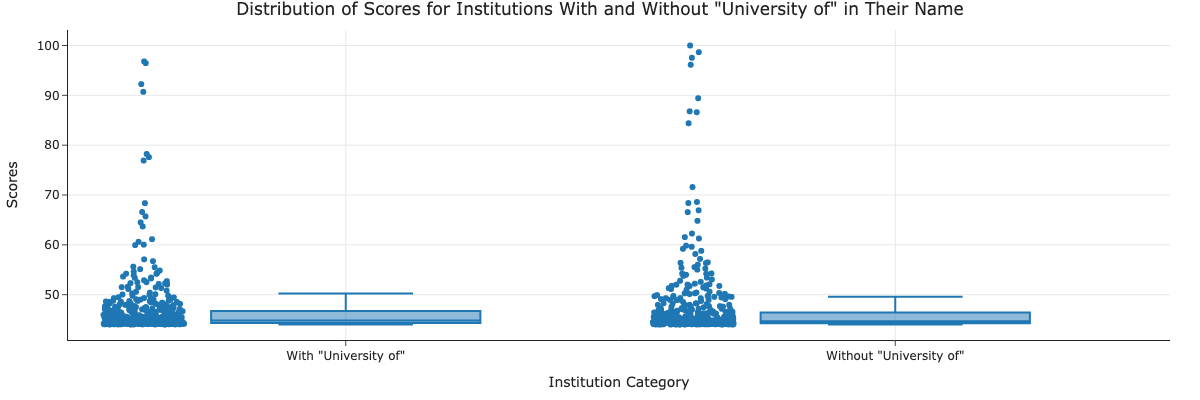

In [120]:
# Run this cell, don't change anything.
save_and_show(plot_university_of(universities), 'imgs/q05_1.png')

#### Question 5.2 <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">5 Points</div>

One of the most important skills a data scientist needs to master is the ability to _think_ of questions. That's what you'll need to do here.

**Your job is to think of an interesting question you might want to answer using the data `universities`, and then draw a visualization to help answer it.** Your visualization must involve at least one numerical feature and at least one categorical feature (potentially, one that you construct by taking an existing numerical feature and "binning" it, as we did in Question 1). The distribution of a single categorical feature is not _interesting_ enough, i.e. your question needs to be more sophisticated than "Which states have the most public universities?" with an accompanying bar chart.

Complete the implementation of the function `custom_vis`, which takes in a DataFrame `df` like `universities` and returns a **`plotly` Figure object** containing your visualization. **Then, in the cell beneath it, tell us the question you tried to answer, and give us 1-2 sentences describing your takeaways.**

This question will mostly be graded on effort. Meet the requirements above and you'll get full credit. That said, take pride in your work, and try your best to make a really special plot that others won't. Are you really proud of what you made? [**Post it in this Ed post**](https://edstem.org/us/courses/61012/discussion/5320217).

<div class="alert alert-danger">

Like the plot above, this one will be manually graded, **not** autograded! To make sure we can grade your work correctly, once you're done implementing `custom_vis`:

1. Comment out the line at the bottom of the cell above, that just has `custom_vis(universities)`.
2. Run the cell that calls the function `save_and_show`. You should see a static (i.e. not interactive) version of your plot. This is to be expected. (This is what we'll use to grade your work.)

Here, remember to provide your analysis of your plot in the cell below the one in which `save_and_show` is run.

</div>

In [166]:
def custom_vis(df):
    df_top_100 = df[df['world_rank'] <= 100]
    df_rankings = (
        df_top_100
        .groupby('nation')['world_rank']
        .apply(lambda x: '[' + ', '.join(x.astype(str)) + ']')
        .reset_index(name='rankings')
    )
    df_counts = (
        df_top_100
        .groupby('nation')
        .size()
        .reset_index(name='institution_count')
    )
    custom_df = pd.merge(df_counts, df_rankings, on='nation')

    fig = px.pie(custom_df, names='nation', values='institution_count', hover_data={'rankings': True})
    return fig

# When you're ready to submit your homework, please comment the line below out;
# otherwise, we won't be able to manually grade your work.
custom_vis(universities)

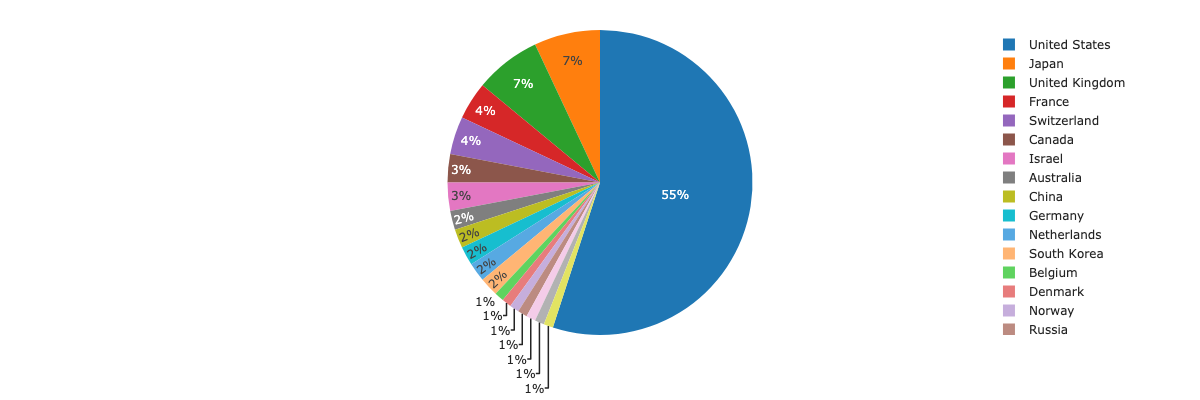

In [165]:
# Run this cell, don't change anything.
save_and_show(custom_vis(universities), 'imgs/q05_2.png')

My question was: Which nations have these best institutions? The US has the majority of the top 100 universities, at 55%. However, the UK is equally impressive, although it has far less in the top 100, it holds the #4 and #5 spots (you can see details in the hover info). Japan and Switzerland are also nations without many top 100 institutions, but have their own share of institutions in the top 20. Perhaps this is due to these nations being smaller in population, thus having less institutions that could be in the top 100, however, having equally impressive education quality.

## Part 3: What's Missing? 👀

---

In [Lecture 8](https://practicaldsc.org/resources/lectures/lec08/lec08-filled.html), we learned about different **imputation strategies** for filling in missing values. Here, we'll take things a step further and develop a few more related strategies.

### Question 6: Conditioning on a Numerical Feature 🧍📏 <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">4 Points</div>

In Lecture 8, you learned how to perform mean imputation conditionally on a **categorical** column: impute with the mean for each group. That is, for each distinct value of the **categorical** column, there is a single imputed value.

Here, you will perform single-valued imputation by conditioning on a **numerical** column. This is not something we learned how to do in class. 

You will work with a version of the `heights` DataFrame from class, now called `new_heights`, that has a `'father'` column and a single `'child'` column. The `'child'` column has missing values. To impute the `'child'` column, transform the `'father'` column into a categorical column by binning the values of `'father'` into [quartiles](https://en.wikipedia.org/wiki/Quartile). Once this is done, you can impute `'child'` as in lecture (and described above).

In [168]:
new_heights = pd.read_csv('data/missing_heights.csv')
new_heights.head()

,father,child
0,78.5,NaN
1,78.5,NaN
2,78.5,69.0
3,78.5,69.0
4,75.5,73.5


Complete the implementation of the function `cond_single_imputation`, which takes in a DataFrame `df` like `new_heights` with columns `'father'` and `'child'` (where `'child'` has missing values) and performs a single-valued mean imputation of the `'child'` column, conditional on `'father'`. `cond_single_imputation` should return a **Series** with just the imputed `'child'` heights.

Example behavior is given below.

```python
>>> cond_single_imputation(new_heights).head(5)
0    68.083871
1    68.083871
2    69.000000
3    69.000000
4    73.500000
```

Some guidance:
- There's likely a new `pandas` function you needed to research and use in Question 1. If you use that here, you'll be able to write a two-line solution.
- If you use the `pandas` function above that we're talking about, you'll likely want to convert your column with group labels in it to hold type `str` (or `object`), otherwise you'll run into a `FutureWarning`.

In [198]:
def cond_single_imputation(df):
    df['father'] = df['father'].astype(str)
    global_mean = df['child'].mean()
    return (
        df
        .groupby('father')
        ['child']
        .transform(
            lambda x: x.fillna(x.mean() if x.mean() == x.mean() else global_mean)
        )
    )

# Feel free to change this input to make sure your function works correctly.
cond_single_imputation(new_heights)

0      69.0
1      69.0
2      69.0
3      69.0
4      73.5
       ... 
929    64.0
930    62.0
931    63.0
932    66.5
933    66.5
Name: child, Length: 934, dtype: float64

In [199]:
grader.check("q06")

q06 results: All test cases passed!

### Question 7: Advanced Probabilistic Imputation 🎲 <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">5 Points</div>

In [Lecture 8](https://practicaldsc.org/resources/lectures/lec08/lec08-filled.html), you learned how to impute a quantitative column by sampling from the observed values. **One problem with this technique is that the imputation will never generate imputed values that weren't already in the dataset.** For example, 57, 57.5, and 59 are values in the `'child'` column of `new_heights` while 58 is not. Thus, any imputation done by sampling from the observed values in the `'child'` column will not be able to generate a height of 58, even though it's clearly a reasonable value to occur in the dataset.

To keep things simple, you will impute the `'child'` column **unconditionally** from the distribution of `'child'` heights present in the dataset. This means that you will use the values present in `'child'` to impute missing values, without looking at other columns.

An approach to quantitative imputation that overcomes the limitation mentioned above is as follows:
- Create a histogram of observed `'child'` heights, using 10 bins.
- Use the histogram to generate a new `'child'` height to impute with, somewhere within the observed range of `'child'` heights:
    - The probability a generated `'child'` height will come from a given bin is equal to the proportion of `'observed'` values in that bin. For example, if 20\% of observed `'child'` heights fall within a particular bin, then there's a 20\% chance we select that bin to draw a new `'child'` height from.
    - Once we select a bin, any value within that bin's left and right endpoints is equally likely to be drawn. For example, if we selected the bin [12, 14), we could choose any real number between 12 (inclusive) and 14 (exclusive) to fill in as our missing `'child'` height; `np.random.uniform` can help us pick that number between 12 and 14.
    
Let's illustrate this approach with an example. Let `demo` be the array of 10 numbers defined below.

```python
demo = np.array([10, 11, 11, 13, 14, 14, 13.5, 14, 15, 16])
```

- The first step is creating a histogram of `demo`. Note that with this example dataset, we will use 4 bins, **but you will be using 10 bins** in your imputation process.

<center><img src='imgs/histogram-demo.png' width=700></center>

- Note that in your implementation, you don't actually need to draw a histogram – instead, use `np.histogram`. (Play around with it to figure out how it works.)
- In the histogram above, we see that $\frac{3}{10}$ of values lie in the [10, 12) bin, $\frac{2}{10}$ of values lie in the [12, 14) bin, $\frac{4}{10}$ of values lie in the [14, 16) bin, and $\frac{1}{10}$ of values lie in the [16, 18] bin.
- Next, we need to pick a bin at random. There's a 30\% chance we pick the [10, 12) bin, a 20\% chance we pick the [12, 14) bin, a 40\% chance we pick the [14, 16) bin, and a 10\% chance we pick the [16, 18] bin. `np.random.choice` will be helpful in picking a bin at random.
- Once we pick a bin, we pick a number **uniformly at random** from within the bin. For instance, suppose we randomly chose the [14, 16) bin in the previous step. We then must select a (real) number between 14 and 16 uniformly at random; as mentioned above, `np.random.uniform` can help us here.

Complete the implementation of the function `impute_height_quant`, which takes in a Series `s` like `heights['child']`, in which some values are missing, and returns a Series in which the values are imputed using the histogram scheme above. The length of the returned Series should be the same as the length of `s`.

Example behavior is given below.

```python
>>> impute_height_quant(new_heights['child']).head(5)
0    69.283202            # Randomly chosen!
1    69.208524            # Randomly chosen!
2    69.000000
3    69.000000
4    73.500000
```

Some guidance:
- You _can_ use a `for`-loop if needed.
- As always, it's good practice to define a helper function!

In [202]:
def impute_height_quant(s):
    observed = s.dropna()
    counts, bin_edges = np.histogram(observed, bins=10)
    probabilities = counts / counts.sum()

    def impute_value():
        bin_index = np.random.choice(len(bin_edges) - 1, p=probabilities)
        return np.random.uniform(bin_edges[bin_index], bin_edges[bin_index + 1])

    imputed_values = s.apply(lambda x: impute_value() if pd.isnull(x) else x)
    return imputed_values

# Feel free to change this input to make sure your function works correctly.
impute_height_quant(new_heights['child'])

0      64.221180
1      71.991205
2      69.000000
3      69.000000
4      73.500000
         ...    
929    64.000000
930    62.000000
931    66.931279
932    66.500000
933    63.018011
Name: child, Length: 934, dtype: float64

In [203]:
grader.check("q07")

q07 results: All test cases passed!

## Finish Line 🏁

Congratulations! You're ready to submit Homework 4.

To submit your homework:

1. Select `Kernel -> Restart & Run All` to ensure that you have executed all cells, including the test cells.
2. Read through the notebook to make sure everything is fine and all tests passed.
3. Run the cell below to run all tests, and make sure that they all pass.
4. Download your notebook using `File -> Download as -> Notebook (.ipynb)`, then upload your notebook to Gradescope under "Homework 4".
5. Stick around while the Gradescope autograder grades your work. Make sure you see that all **public tests** have passed on Gradescope. **Remember that homeworks have hidden tests, which you will not see your scores on until a few days after the deadline!**
6. Check that you have a confirmation email from Gradescope and save it as proof of your submission.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [204]:
grader.check_all()

q01 results: All test cases passed!

q02 results: All test cases passed!

q03 results: All test cases passed!

q04 results: All test cases passed!

q06 results: All test cases passed!

q07 results: All test cases passed!